# UFC Betting

## Data Loading and Merging

In [1]:
from pathlib import Path

import pandas as pd

data_path = Path().cwd().parent / 'data' / 'external' / 'ufc-master.csv'

df = pd.read_csv(data_path)

In [2]:
pattern_dif = r'_dif$'
df_dif = df.filter(regex=pattern_dif)

pattern_b = r'^B_'
df_b = df.filter(regex=pattern_b)

pattern_r = r'^R_'
df_r = df.filter(regex=pattern_r)

In [3]:
other_cols = df_dif.columns.append(df_b.columns).append(df_r.columns)

df_info = df.drop(other_cols, axis=1)

df2 = pd.concat([df_info, df_dif], axis=1)

df3 = pd.concat([
    df2,
    df_b[['B_fighter', 'B_odds']],
    df_r[['R_fighter', 'R_odds']]
],
    axis=1)

df3.info()


In [4]:
ufc = df3.drop(['finish_details', 'constant_1'], axis=1)

ufc.dropna(inplace=True)

----

## EDA
### **Question:** Who will win the fight?

In [5]:
pd.set_option('display.max_columns', None) # set to view all columns
 
ufc.head()

,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,empty_arena,better_rank,finish,finish_round,finish_round_time,total_fight_time_secs,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,B_fighter,B_odds,R_fighter,R_odds
233,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Light Heavyweight,MALE,3,1,Red,U-DEC,3.0,5:00,900.0,0,0,1,-6,-6,-31,-1,-4,-3,0.00,5.08,-4,1.98,-0.4,0.75,Aleksandar Rakic,-278.0,Anthony Smith,225.0
234,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,MALE,3,1,Red,U-DEC,3.0,5:00,900.0,-3,2,2,-3,-7,-30,-6,-7,1,10.16,15.24,-5,0.38,0.3,1.84,Neil Magny,-250.0,Robbie Lawler,200.0
235,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Women's Flyweight,FEMALE,3,1,Blue,U-DEC,3.0,5:00,900.0,1,-1,-1,0,1,2,0,-1,0,-5.08,-15.24,-3,0.76,0.6,0.19,Alexa Grasso,-315.0,Ji Yeon Kim,230.0
236,8/29/2020,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,3,1,neither,U-DEC,3.0,5:00,900.0,-1,0,-4,-14,-8,-48,-1,-5,-3,10.16,5.08,-7,6.92,-1.0,-1.63,Bill Algeo,240.0,Ricardo Lamas,-335.0
237,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,3,1,neither,U-DEC,3.0,5:00,900.0,-1,0,-1,-1,-2,-6,0,-1,0,2.54,0.00,-3,0.58,-0.6,0.23,Impa Kasanganay,-139.0,Maki Pitolo,115.0


List of fixes:

1. Normalize weight class -> take out gender from weight class since we already have gender column
2. Remove columns known after the fight for who will win analysis
3. Convert date to feature columns

In [6]:
ufc['date'] = pd.to_datetime(ufc['date']) # converting to dt

# get month, day, year vals as objs
ufc['year'] = ufc['date'].dt.year.astype('object')
ufc['month'] = ufc['date'].dt.month.astype('object')
ufc['day'] = ufc['date'].dt.day.astype('object')

ufc.drop('date', axis=1, inplace=True) # drop orig col

ufc.head()[['day', 'month', 'year']] # show result of transformation

,day,month,year
233,29,8,2020
234,29,8,2020
235,29,8,2020
236,29,8,2020
237,29,8,2020


In [7]:
ufc.drop(['no_of_rounds', 'finish_round', 'total_fight_time_secs', 'finish', 'finish_round_time'], 
          axis=1, inplace=True) # removing after the fact cols

In [8]:
ufc['weight_class'] = ufc['weight_class'].str.replace("Women\'s", "") # removing extra text since gender is given in col

In [9]:
ufc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4099 entries, 233 to 4587
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location                4099 non-null   object 
 1   country                 4099 non-null   object 
 2   Winner                  4099 non-null   object 
 3   title_bout              4099 non-null   bool   
 4   weight_class            4099 non-null   object 
 5   gender                  4099 non-null   object 
 6   empty_arena             4099 non-null   int64  
 7   better_rank             4099 non-null   object 
 8   lose_streak_dif         4099 non-null   int64  
 9   win_streak_dif          4099 non-null   int64  
 10  longest_win_streak_dif  4099 non-null   int64  
 11  win_dif                 4099 non-null   int64  
 12  loss_dif                4099 non-null   int64  
 13  total_round_dif         4099 non-null   int64  
 14  total_title_bout_dif    4099 non-null 

In [10]:
ufc['title_bout'] = ufc['title_bout'].astype('object') # changing to obj for consistency

In [11]:
ufc.describe()

,empty_arena,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,B_odds,R_odds
count,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000
mean,0.040010,0.136863,-0.172481,-0.774335,-1.381313,0.555257,-5.069529,-0.346426,-0.481337,-0.275433,0.144899,-0.137072,0.506709,-3.942993,-0.061973,-0.219809,69.787753,-119.884606
std,0.196006,0.976570,1.732125,2.016057,3.933159,2.757758,15.474449,1.682749,2.032635,1.741747,6.448511,9.218362,5.138125,23.987448,0.810325,1.648988,250.972260,271.166345
min,0.000000,-5.000000,-12.000000,-12.000000,-26.000000,-17.000000,-84.000000,-16.000000,-13.000000,-13.000000,-33.020000,-187.960000,-16.000000,-118.000000,-6.000000,-11.000000,-1200.000000,-1700.000000
25%,0.000000,0.000000,-1.000000,-2.000000,-3.000000,-1.000000,-12.000000,0.000000,-1.000000,-1.000000,-5.080000,-5.080000,-3.000000,-17.333333,-0.409091,-1.000000,-145.000000,-255.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.111111,0.000000,0.000000,135.000000,-150.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,5.080000,5.080000,4.000000,7.386472,0.234091,0.531818,225.000000,125.500000
max,1.000000,6.000000,9.000000,14.000000,19.000000,16.000000,60.000000,14.000000,11.000000,9.000000,30.480000,30.480000,17.000000,128.222222,6.000000,10.000000,1300.000000,775.000000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

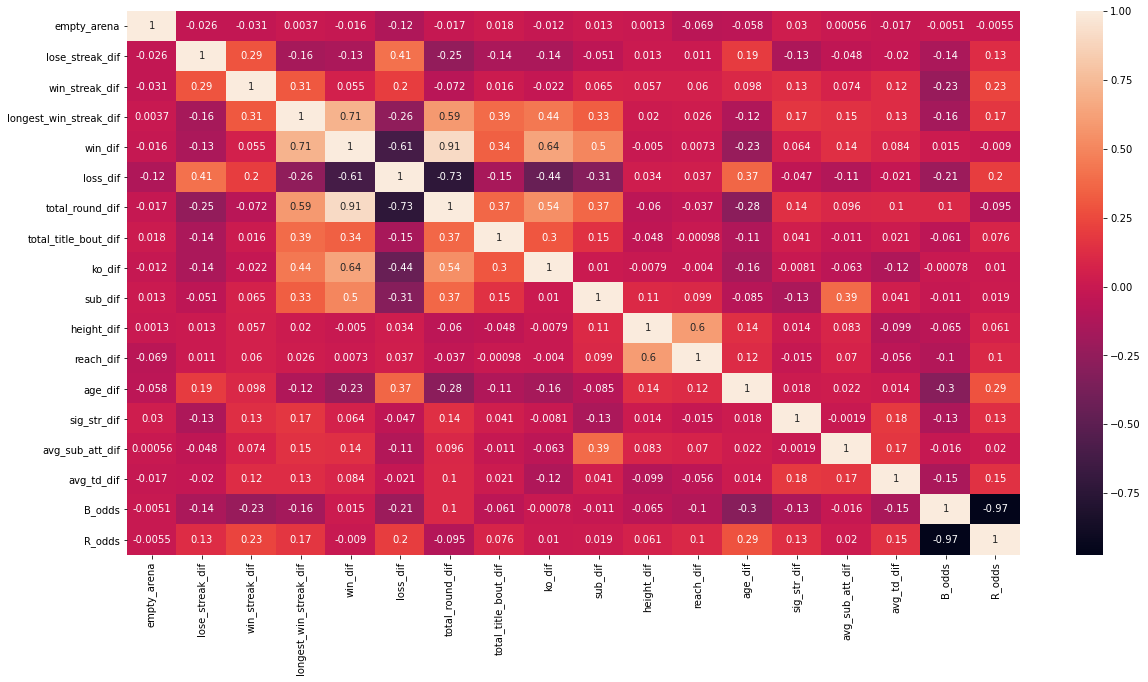

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(ufc.corr(), annot=True)

Notes on correlation heatmap:

* There may be a problem with some of these **so we'll run a VIF analysis once data is cleaned all the way**
* These correlations make sense such as experience leading to better performance

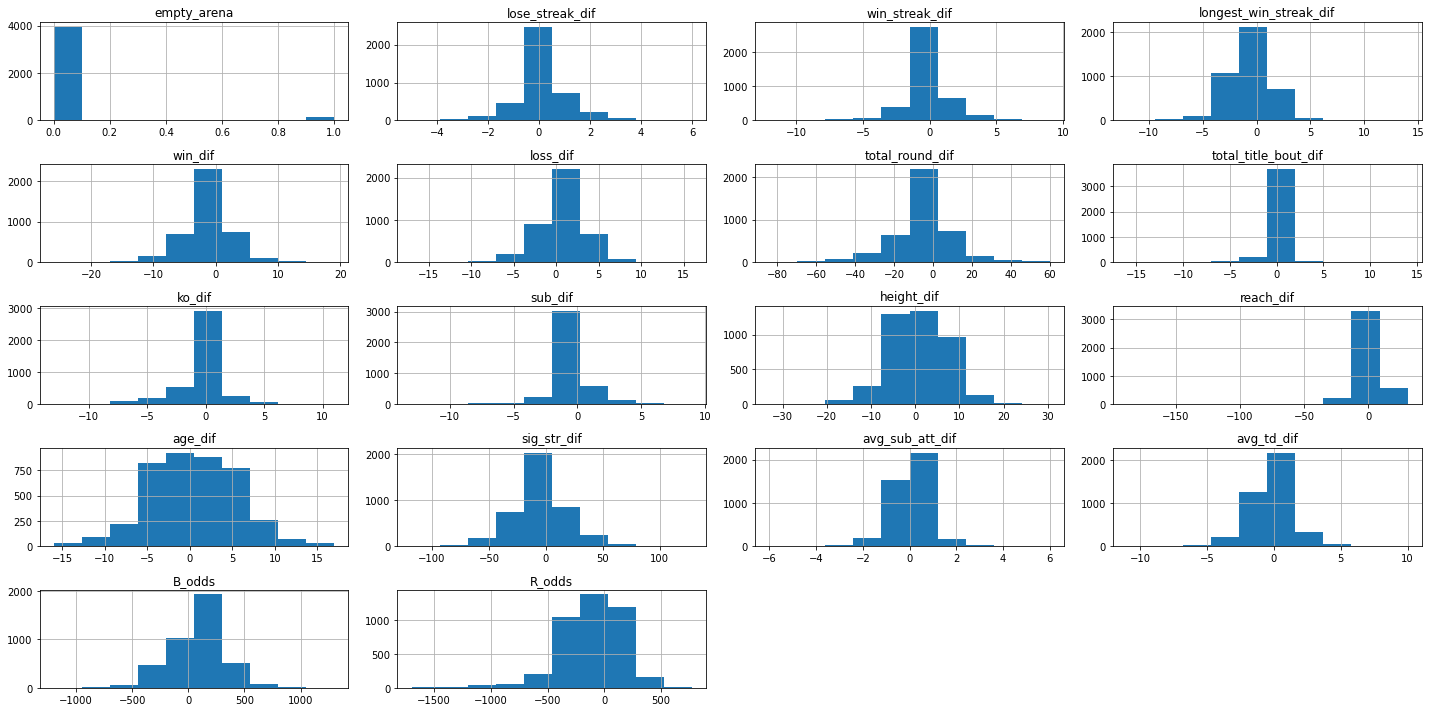

In [14]:
ufc.hist(figsize=(20,10))
plt.tight_layout()

Distribution notes:

* The differentials look nice and normal
* Need to bucket some of these, such as:
    * Empty arena
* Outliers to explore:
    * Odds for both corners
    * Reach differential

In [15]:
ufc['empty_arena'] = ufc['empty_arena'].astype('object') # converting arena status to object

<AxesSubplot:>

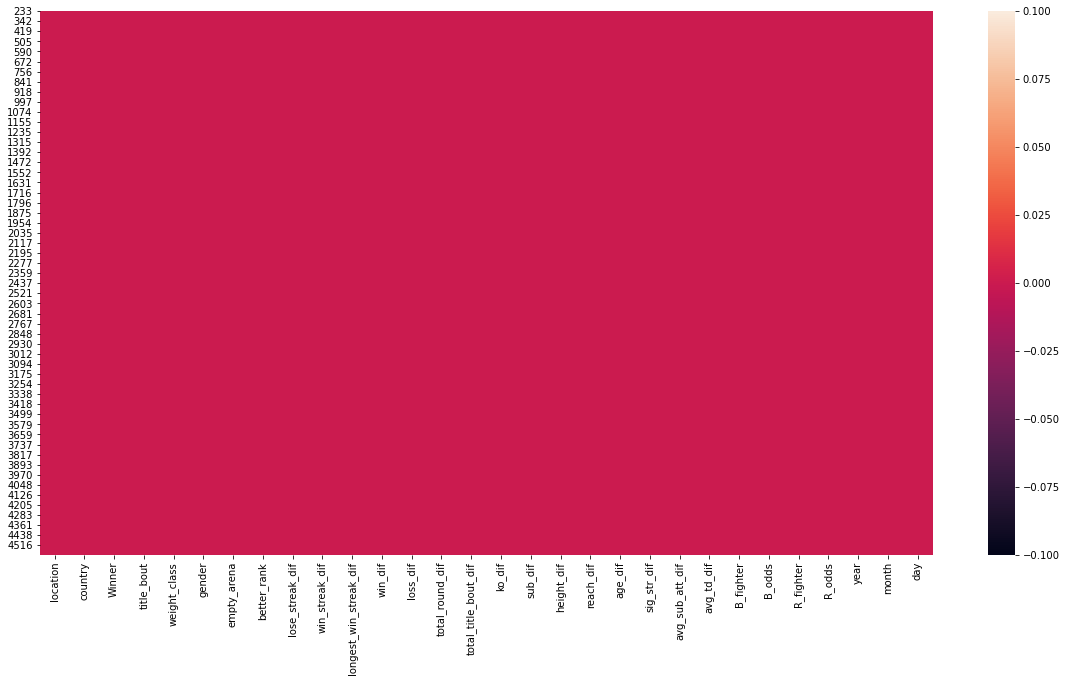

In [16]:
plt.figure(figsize=(20,10))
sns.heatmap(ufc.isna())

Missing value notes:

* No missing values!

In [17]:
for col in ufc.select_dtypes('object').columns:
    ufc[col] = ufc[col].apply(lambda x: str(x).strip()) # fixing whitespace issues

In [18]:
print('Categorical Counts:')
print()
for col in ufc.select_dtypes('object').columns:
    print(ufc.groupby(col)[col].count().sort_values(ascending=False))
    print()
    print('----------------------------------------------------------------------------------------------')
    print()

Categorical Counts:

location
Las Vegas, Nevada, USA               790
Newark, New Jersey, USA               77
Chicago, Illinois, USA                76
Toronto, Ontario, Canada              71
London, England, United Kingdom       70
                                    ... 
Beijing, China                         8
Saitama, Saitama, Japan                8
Gold Coast, Queensland, Australia      7
Manila, Philippines                    7
Shenzhen, Guangdong, China             6
Name: location, Length: 145, dtype: int64

----------------------------------------------------------------------------------------------

country
USA                     2490
Brazil                   380
Canada                   323
United Kingdom           155
Australia                152
United Arab Emirates      78
Sweden                    68
Mexico                    61
Germany                   52
Japan                     49
China                     42
Singapore                 37
Russia                  

Notes after categorical counts:

* Removing specific locations and only keeping countries
* **Create hierarchical ordering for weight classes** to remove dimensions
* Not using the fighter name in model

-----
## Code Annex

In [19]:
# # VIF CODE TO USE AFTER CLEANING

# from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# # the independent variables set
# X = ufc.select_dtypes('number')
  
# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# print(vif_data)